In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold

In [2]:
df_large = pd.read_csv("large_preprocessed_week_24-05-2024.csv", low_memory=False)
df_large = df_large.drop(df_large.columns[0], axis=1)

In [3]:
df = df_large

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
df.head()

,TRAFFIC_DATE,TRAINNUMBER,TRAINSERIE,TRAINSERIE_DIRECTION,STATION,ACTIVITYTYPE,DISTANCE_M,PLAN_DATETIME,REALIZED_DATETIME,DELAY,TURNOVER_INDICATOR,PREVIOUS_TRAINNUMBER,COMBINE,SPLIT,ROLLINGSTOCK_TYPE,NUMBER_CARRIAGES,DRIVER_CHANGE,DEPARTURE_SIGNAL_SHOWS_SAFE,CUM_DISTANCE_M,PLAN_TURNOVER_TIME,REALIZED_TURNOVER_TIME,MAX_DEPARTURE_TIME,PLAN_SIGNAL_SAFE_DELAY,REALIZED_SIGNAL_SAFE_DELAY,DALUREN,DAY_OF_WEEK,HOUR,DAY_OF_WEEK_sin,DAY_OF_WEEK_cos,HOUR_sin,HOUR_cos,NEEDED_PLAN_TURNOVER_TIME,NEEDED_REALIZED_TURNOVER_TIME,DIFF_TURNOVER_TIME,DIFF_TURNOVER_TIME_CAT
0,2023-01-01,11736,11700.0,E,Ut,V,0.0,2023-01-01 11:58:00+00:00,2023-01-01 11:59:02+00:00,62.0,1,NaN,0,0,DDZ,6.0,1,2023-01-01 11:57:07+00:00,24051.0,300.0,193.0,NaN,-53.0,-115.0,True,6,11,-0.781831,0.62349,2.588190e-01,-0.965926,298.0,191.0,107.0,too late
1,2023-01-01,11740,11700.0,E,Ut,V,0.0,2023-01-01 12:58:00+00:00,2023-01-01 12:57:59+00:00,-1.0,1,NaN,0,0,DDZ,6.0,1,2023-01-01 12:57:08+00:00,24051.0,300.0,279.0,NaN,-52.0,-51.0,True,6,12,-0.781831,0.62349,1.224647e-16,-1.000000,361.0,340.0,21.0,perfect
2,2023-01-01,11741,11700.0,O,Ut,V,0.0,2023-01-01 12:07:00+00:00,2023-01-01 12:07:25+00:00,25.0,1,NaN,0,0,DDZ,6.0,1,2023-01-01 12:06:07+00:00,60252.0,300.0,330.0,NaN,-53.0,-78.0,True,6,12,-0.781831,0.62349,1.224647e-16,-1.000000,335.0,365.0,-30.0,perfect
3,2023-01-01,11744,11700.0,E,Ut,V,0.0,2023-01-01 13:58:00+00:00,2023-01-01 13:58:09+00:00,9.0,1,NaN,0,0,ICM,6.0,1,2023-01-01 13:57:07+00:00,24051.0,300.0,223.0,NaN,-53.0,-62.0,True,6,13,-0.781831,0.62349,-2.588190e-01,-0.965926,351.0,274.0,77.0,too late
4,2023-01-01,11745,11700.0,O,Ut,V,0.0,2023-01-01 13:07:00+00:00,2023-01-01 13:07:20+00:00,20.0,1,NaN,0,0,ICM,6.0,1,2023-01-01 13:06:07+00:00,60252.0,300.0,349.0,NaN,-53.0,-73.0,True,6,13,-0.781831,0.62349,-2.588190e-01,-0.965926,340.0,389.0,-49.0,perfect


In [5]:
df = df[df['NUMBER_CARRIAGES'].notna()]
df["NUMBER_CARRIAGES"] = df["NUMBER_CARRIAGES"].astype(int)

C:\Users\Tim Rentenaar\AppData\Local\Temp\ipykernel_8276\368654501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NUMBER_CARRIAGES"] = df["NUMBER_CARRIAGES"].astype(int)


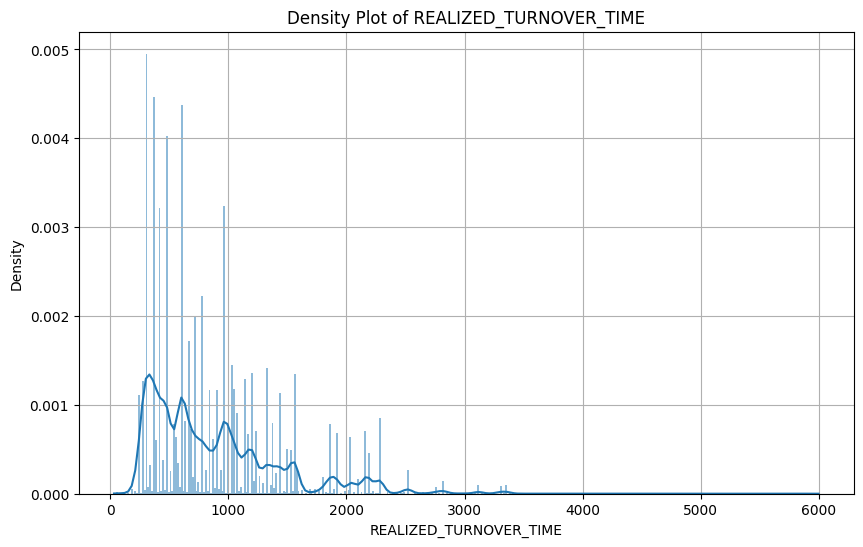

In [6]:
# Creating the density plot
plt.figure(figsize=(10, 6))
sns.histplot(df["PLAN_TURNOVER_TIME"], kde=True, stat="density", linewidth=0)
plt.title('Density Plot of REALIZED_TURNOVER_TIME')
plt.xlabel('REALIZED_TURNOVER_TIME')
plt.ylabel('Density')
plt.grid(True)
plt.show()

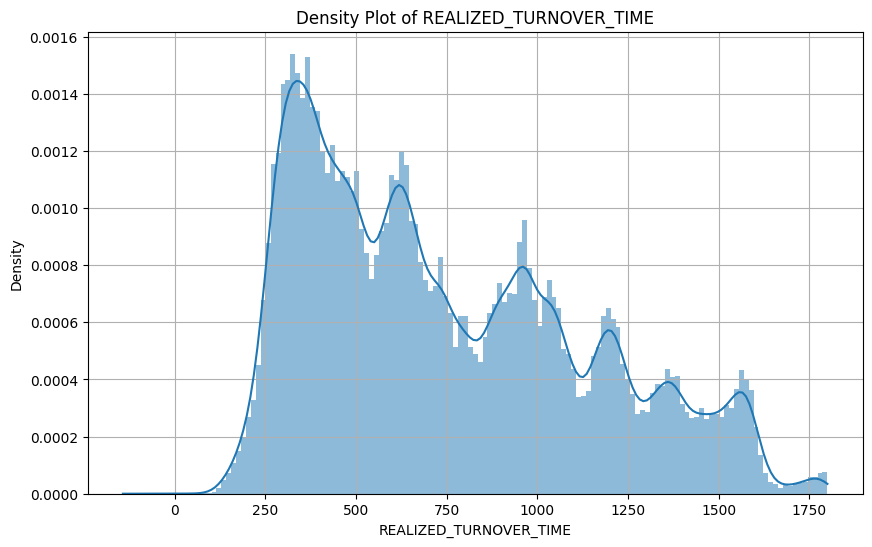

In [7]:
df = df[df["DELAY"] <= 180]
df = df[df["REALIZED_TURNOVER_TIME"] <= 1800]

# Creating the density plot
plt.figure(figsize=(10, 6))
sns.histplot(df["REALIZED_TURNOVER_TIME"], kde=True, stat="density", linewidth=0)
plt.title('Density Plot of REALIZED_TURNOVER_TIME')
plt.xlabel('REALIZED_TURNOVER_TIME')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [8]:
df = df[["REALIZED_TURNOVER_TIME", "PLAN_TURNOVER_TIME", "STATION", "ROLLINGSTOCK_TYPE", "NUMBER_CARRIAGES","DRIVER_CHANGE","DAY_OF_WEEK_sin","DAY_OF_WEEK_cos","HOUR_sin","HOUR_cos"]]
df = df.dropna()
df = pd.get_dummies(df, columns=['STATION', 'ROLLINGSTOCK_TYPE'], drop_first=False)

In [9]:
y = df["REALIZED_TURNOVER_TIME"]
X = df.drop(columns=["REALIZED_TURNOVER_TIME","PLAN_TURNOVER_TIME"])

# Baseline models

## Current method

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(df["REALIZED_TURNOVER_TIME"], df["PLAN_TURNOVER_TIME"])
mse = mean_squared_error(df["REALIZED_TURNOVER_TIME"], df["PLAN_TURNOVER_TIME"])
r2 = r2_score(df["REALIZED_TURNOVER_TIME"], df["PLAN_TURNOVER_TIME"])

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 42.6321268691572
Mean Squared Error: 3361.8877837418354
R-squared: 0.9772630440770601


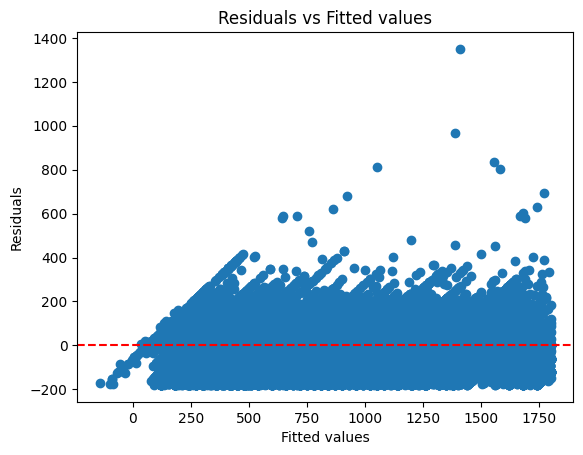

In [11]:
import matplotlib.pyplot as plt

residuals = df["REALIZED_TURNOVER_TIME"] - df["PLAN_TURNOVER_TIME"]

# Plot residuals vs. fitted values
plt.scatter(df["REALIZED_TURNOVER_TIME"], residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

## Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
# Cross-validated predictions
y_pred = cross_val_predict(model, X, y, cv=kf)

In [15]:
# Fit the model to compute residuals
model.fit(X, y)
residuals = y - model.predict(X)

In [16]:
residuals = y - y_pred

In [17]:
y_pred_80 = y_pred + residuals.quantile(0.8)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
pbloss = mean_pinball_loss(y, y_pred_80, alpha=0.8)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Pinball loss:", pbloss)

Mean Absolute Error: 117397062.78298526
Mean Squared Error: 1.1582695372003441e+21
R-squared: -7833552190994412.0
Pinball loss: 91018171.98324674


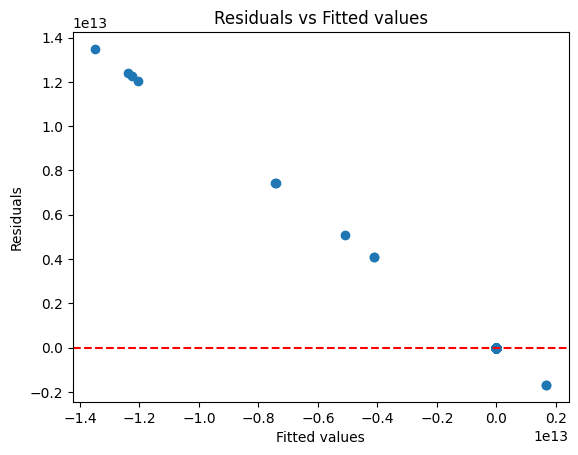

In [19]:
import matplotlib.pyplot as plt

# Plot residuals vs. fitted values
plt.scatter(y_pred, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

## Random Forest Quantile Regression

In [20]:
from sklearn_quantile import SampleRandomForestQuantileRegressor

In [21]:
# Initialize the model
rf_quantile = SampleRandomForestQuantileRegressor(q=0.8, random_state=42, min_samples_split = 50, n_estimators = 200)

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
# Cross-validated predictions
y_pred_80 = cross_val_predict(rf_quantile, X, y, cv=kf)

C:\Users\Tim Rentenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Tim Rentenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\parallel.py:118: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Tim Rentenaar\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Tim Ren

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss

pbloss = mean_pinball_loss(y, y_pred_80, alpha=0.8)

print("Pinball loss:", pbloss)

Pinball loss: 91018187.6915313
